<a href="https://colab.research.google.com/github/pastatimes/Master-Thesis-HateSpeech-Twitter/blob/master/BERT_sentence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Using Colab GPU for training**


In [0]:
# source: https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=DEfSbAA4QHas
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


**Installing Hugging face library**

In [0]:
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 890kB 14.5MB/s 
     |████████████████████████████████| 3.8MB 17.5MB/s 
     |████████████████████████████████| 1.1MB 31.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b95dddaf9a24e30bcf481f15ec28e4f4f0ca03a76797e8dc7255e42f1b6c99b5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


**Loading Dataset**

In [0]:
import pandas as pd

filename = '/content/drive/My Drive/Annotated tweets/2020-2.xls'
data = pd.read_excel(filename)
data

,gg_id,text,intent.id,intent.name,created_at,id_str
0,A2ac338e0,Asian Americans are VERY angry at what China h...,Neutral,Neutral,2020-12-05 11:19:00,1260000000000000000
1,Ef9e3fbf3,.@CBS and their show @60Minutes are doing ever...,HateSpeech,Hate Speech,2020-10-05 23:25:00,1260000000000000000
2,G33efcef2,We are getting great marks for the handling of...,HateSpeech,Hate Speech,2020-10-05 11:48:00,1260000000000000000
3,Ib6c34b77,MSDNC and FAKE NEWS CNN are going wild trying ...,OffensiveLanguage,Offensive Language,2020-04-05 22:35:00,1260000000000000000
4,Ud7f5e93c,Mexico is sadly experiencing very big CoronaVi...,OffensiveLanguage,Offensive Language,2020-04-05 13:42:00,1260000000000000000
...,...,...,...,...,...,...
67,V5f3b8de7,The Fake News Media and their Democrat Partner...,OffensiveLanguage,Offensive Language,01-13-2020 16:09:17,1220000000000000000
68,X9078b256,The Democrats and the Fake News are trying to ...,OffensiveLanguage,Offensive Language,01-13-2020 15:47:16,1220000000000000000
69,Q0ba10a09,The Fake News Media and their Democrat Partner...,OffensiveLanguage,Offensive Language,01-13-2020 15:42:46,1220000000000000000
70,R5f86562b,Where have the Radical Left Do Nothing Democra...,OffensiveLanguage,Offensive Language,2020-11-01 14:07:00,1220000000000000000


In [0]:
#choose the colomn on which you want to train the model
class_of_interest = 'intent.id'

In [0]:
def labelTrans(row):
  if row[class_of_interest] == 'Neutral':
    return 0
  if row[class_of_interest] == 'OffensiveLanguage':
    return 1
  if row[class_of_interest] == 'HateSpeech':
    return 2

In [0]:
data[class_of_interest] = data.apply(lambda row: labelTrans(row), axis=1)
data

,gg_id,text,intent.id,intent.name,created_at,id_str
0,A2ac338e0,Asian Americans are VERY angry at what China h...,0,Neutral,2020-12-05 11:19:00,1260000000000000000
1,Ef9e3fbf3,.@CBS and their show @60Minutes are doing ever...,2,Hate Speech,2020-10-05 23:25:00,1260000000000000000
2,G33efcef2,We are getting great marks for the handling of...,2,Hate Speech,2020-10-05 11:48:00,1260000000000000000
3,Ib6c34b77,MSDNC and FAKE NEWS CNN are going wild trying ...,1,Offensive Language,2020-04-05 22:35:00,1260000000000000000
4,Ud7f5e93c,Mexico is sadly experiencing very big CoronaVi...,1,Offensive Language,2020-04-05 13:42:00,1260000000000000000
...,...,...,...,...,...,...
67,V5f3b8de7,The Fake News Media and their Democrat Partner...,1,Offensive Language,01-13-2020 16:09:17,1220000000000000000
68,X9078b256,The Democrats and the Fake News are trying to ...,1,Offensive Language,01-13-2020 15:47:16,1220000000000000000
69,Q0ba10a09,The Fake News Media and their Democrat Partner...,1,Offensive Language,01-13-2020 15:42:46,1220000000000000000
70,R5f86562b,Where have the Radical Left Do Nothing Democra...,1,Offensive Language,2020-11-01 14:07:00,1220000000000000000


In [0]:
#clean file
data = data.dropna()

# label to interger
data[class_of_interest] = data[class_of_interest].astype(int)
data

,gg_id,text,intent.id,intent.name,created_at,id_str
0,A2ac338e0,Asian Americans are VERY angry at what China h...,0,Neutral,2020-12-05 11:19:00,1260000000000000000
1,Ef9e3fbf3,.@CBS and their show @60Minutes are doing ever...,2,Hate Speech,2020-10-05 23:25:00,1260000000000000000
2,G33efcef2,We are getting great marks for the handling of...,2,Hate Speech,2020-10-05 11:48:00,1260000000000000000
3,Ib6c34b77,MSDNC and FAKE NEWS CNN are going wild trying ...,1,Offensive Language,2020-04-05 22:35:00,1260000000000000000
4,Ud7f5e93c,Mexico is sadly experiencing very big CoronaVi...,1,Offensive Language,2020-04-05 13:42:00,1260000000000000000
...,...,...,...,...,...,...
67,V5f3b8de7,The Fake News Media and their Democrat Partner...,1,Offensive Language,01-13-2020 16:09:17,1220000000000000000
68,X9078b256,The Democrats and the Fake News are trying to ...,1,Offensive Language,01-13-2020 15:47:16,1220000000000000000
69,Q0ba10a09,The Fake News Media and their Democrat Partner...,1,Offensive Language,01-13-2020 15:42:46,1220000000000000000
70,R5f86562b,Where have the Radical Left Do Nothing Democra...,1,Offensive Language,2020-11-01 14:07:00,1220000000000000000


In [0]:
# exploring the data
data[class_of_interest].value_counts()

0    37
1    23
2    12
Name: intent.id, dtype: int64

In [0]:
#Extract training and test data from one file
import numpy as np

shuffled = data.sample(frac=1)
result = np.array_split(shuffled, 10) 
test_data = result[0]
train_data = pd.concat([result[1], result[2], result[3], result[4], result[5], result[6], result[7], result[8], result[9]])
train_data

,gg_id,text,intent.id,intent.name,created_at,id_str
41,Ib9febffe,Australiaâ€™s Central Bank cut interest rates ...,0,Neutral,2020-03-03 06:34:00,1230000000000000000
52,Pba11a5cd,Just had a long and very good conversation by ...,0,Neutral,2020-07-02 10:31:00,1230000000000000000
17,Ad2977ffa,The @nytimes story is a Fake just like the â€œ...,1,Offensive Language,04-13-2020 01:09:56,1250000000000000000
16,F41dd1a4a,The @nytimes story is a Fake just like the â€œ...,0,Neutral,04-13-2020 02:08:16,1250000000000000000
42,X73b06b8f,Australiaâ€™s Central Bank cut interest rates ...,0,Neutral,2020-03-03 06:27:00,1230000000000000000
...,...,...,...,...,...,...
55,Yd0c66325,Working closely with China and others on Coron...,0,Neutral,01-30-2020 22:04:35,1220000000000000000
68,X9078b256,The Democrats and the Fake News are trying to ...,1,Offensive Language,01-13-2020 15:47:16,1220000000000000000
5,E45e3b476,....Fake News got it wrong again as always and...,0,Neutral,2020-03-05 20:18:00,1260000000000000000
70,R5f86562b,Where have the Radical Left Do Nothing Democra...,1,Offensive Language,2020-11-01 14:07:00,1220000000000000000


In [0]:
# Check if the training dataset is not significantly different from the whole dataset
train_data[class_of_interest].value_counts()

0    34
1    21
2     9
Name: intent.id, dtype: int64

In [0]:
# Get the lists of sentences and their labels.
sentences = train_data['text'].values
labels = train_data[class_of_interest].values

**Tokenization & Input Formatting**

In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  83


In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 88,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Australiaâ€™s Central Bank cut interest rates and stated it will most likely further ease in order to make up for Chinaâ€™s Coronavirus situation and slowdown. They reduced to 0.5% a record low. Other countries are doing the same thing if not more so. Our Federal Reserve has us....
Token IDs: tensor([  101,  2660,  2050, 30102, 30108,  2015,  2430,  2924,  3013,  3037,
         6165,  1998,  3090,  2009,  2097,  2087,  3497,  2582,  7496,  1999,
         2344,  2000,  2191,  2039,  2005,  2859,  2050, 30102, 30108,  2015,
        21887, 23350,  3663,  1998,  4030,  7698,  1012,  2027,  4359,  2000,
         1014,  1012,  1019,  1003,  1037,  2501,  2659,  1012,  2060,  3032,
         2024,  2725,  1996,  2168,  2518,  2065,  2025,  2062,  2061,  1012,
         2256,  2976,  3914,  2038,  2149,  1012,  1012,  1012,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])


In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   57 training samples
    7 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
from sklearn.metrics import f1_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def get_f1_score(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(pred_flat, labels_flat, average="macro")

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_f1 = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += get_f1_score(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_f1 = total_eval_f1 / len(validation_dataloader)
    print("  F1 score: {0:.2f}".format(avg_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'F1 Score': avg_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.01
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.29
  F1 score: 0.15
  Validation Loss: 1.19
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.98
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.29
  F1 score: 0.15
  Validation Loss: 1.19
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.92
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.29
  F1 score: 0.15
  Validation Loss: 1.20
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.92
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.29
  F1 score: 0.15
  Validation Loss: 1.21
  Validation took: 0:00:00

Training complete!
Total training took 0:00:03 (h:mm:ss)


In [0]:
f1 = []
f1.append([d['F1 Score'] for d in training_stats])

accuracy = []
accuracy.append([d['Valid. Accur.'] for d in training_stats])

loss = []
loss.append([d['Training Loss'] for d in training_stats])

epoch = []
epoch.append([d['epoch'] for d in training_stats])


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


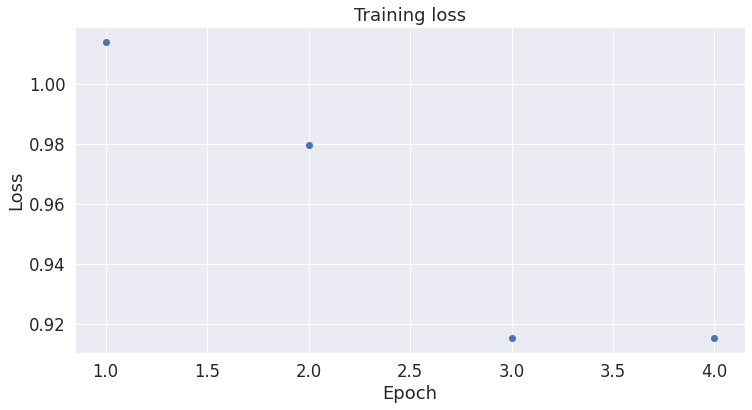

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(epoch, loss, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

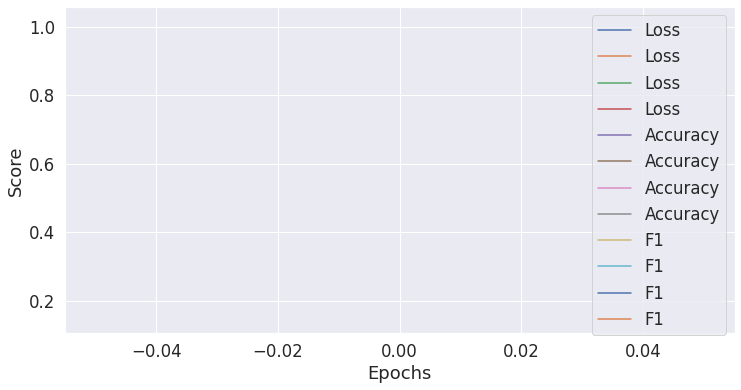

In [0]:
fig, ax = plt.subplots()
n_epochs = range(1,11)
x = epochs
y = [loss[0], accuracy[0[0]], f1]

for name, metric in zip(['Loss', 'Accuracy', 'F1'], y):
    _ = plt.plot(metric, label = name)
    _ = plt.xlabel('Epochs')
    _ = plt.ylabel('Score')
plt.legend(loc="upper right")
plt.show()

In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = test_data

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df['text'].values
labels = df[class_of_interest].values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 8



In [0]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Calculate the accuracy for this batch of test sentences.
  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
  tmp_eval_f1 = get_f1_score(logits, label_ids)
  # Accumulate the total accuracy.
  eval_accuracy += tmp_eval_accuracy
  eval_f1 += tmp_eval_f1

  # Track the number of batches
  nb_eval_steps += 1

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  F1 score: {0:.2f}".format(eval_f1/nb_eval_steps))


NameError: ignored

In [0]:
s = 0
pred_list = []
for b in range(0,len(prediction_dataloader)-1):
  for i in range(0,batch_size):
    pred_dict = {}
    pred_dict['label'] = labels[s]
    pred_dict['check'] = true_labels[b][i]
    pred_dict['sentence'] = sentences[s]
    
    temp = tf.round(tf.nn.softmax(predictions[b][i]))

    if int(temp[0].numpy()) == 1:
      pred_dict['prediction'] = 0

    if int(temp[1].numpy()) == 1:
      pred_dict['prediction'] = 1

    if int(temp[2].numpy()) == 1:
      pred_dict['prediction'] = 2

    if int(temp[3].numpy()) == 1:
      pred_dict['prediction'] = 3

    if pred_dict['prediction'] == pred_dict['label']:
      pred_dict['correct'] = 'yes'
    else:
      pred_dict['correct'] = 'no'

  
    pred_list.append(pred_dict)
    s = s + 1

pred_df = pd.DataFrame(pred_list)
pred_df

In [0]:
pred_df['correct'].value_counts()

In [0]:
temp = pred_df.loc[pred_df['correct'] == 'no']
temp.to_csv('/path/filename.csv')

In [0]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

In [0]:
!ls -l --block-size=K ./model_save/